# Neural Networks

In this first part, we are going to see some useful techniques to build and train Neural Networks. We restrict here to a subclass called Multi Layer Perceptrons (MLP), which basically are a bunch of perceptrons stacked together, as we saw in class (slightly more formally each node of a layer can only be connected to nodes of the next layer). \
We use a library novel for us, **Keras**, that simplifies the process of defining Neural Network architectures and training them. \
Keras documentation: [<a href="https://keras.io/">Link</a>]. \



In [ ]:
# SETUP
# install python 3.10
!apt-get install python3.10

# update symbolic links to the newly installed python version
!ln -sf /usr/bin/python3.10 /usr/bin/python
!ln -sf /usr/bin/python3.10 /usr/bin/python3

# install numpy 1.23.5
%pip install numpy==1.23.5
# install scikit-learn 1.2.2
%pip install scikit-learn==1.2.2
# install keras 2.13.1
%pip install keras==2.13.1
# install tensorflow 2.13.0
%pip install tensorflow==2.13.0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10 is already the newest version (3.10.12-1~22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


### Step 1: create or load data

In [ ]:
import numpy as np
from sklearn import datasets

np.random.seed(123)
X, y = datasets.make_classification(n_samples=2000, n_features=2, random_state=123, n_redundant= 0, scale=10, shift=10)
X[:, 0] = X[:, 0]*0.1

We can now visualize on how our data looks like

Text(0.5, 1.0, 'Random Classification Data with 2 classes')

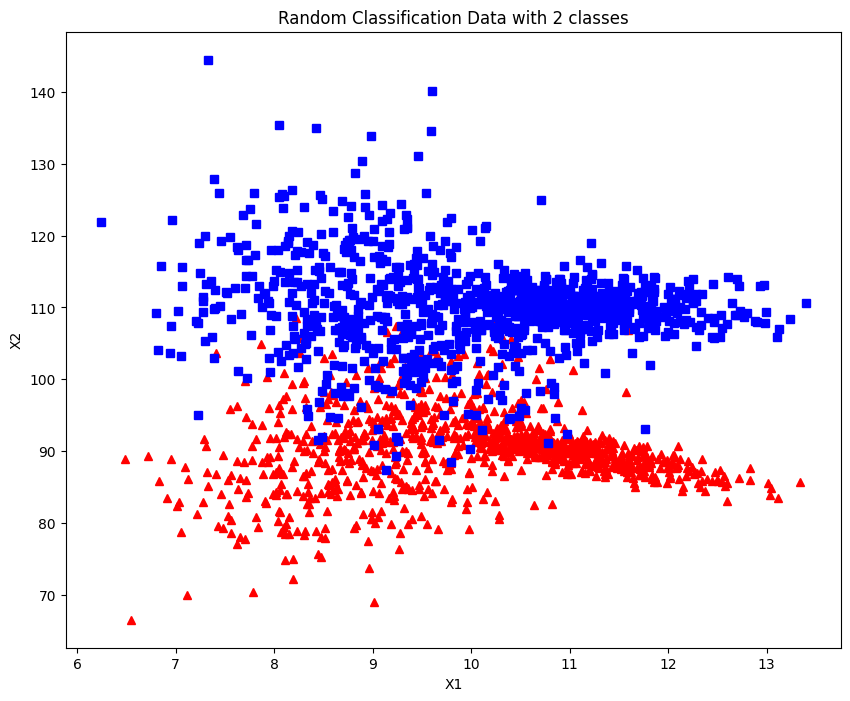

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'r^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title('Random Classification Data with 2 classes')

### Step 2: Train / Test split

As we are going to see later, Keras *fit* function allows us to define the splitting among training and validation (as we similarly did with the scikit-learn *gridsearchCV* function).

We therefore only need to define train (or train_val) and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)

### Step 3: data preprocessing


Let's start by scaling the data. We are going to see the importance of this operation later during the exercises.

In [ ]:
# step 3.1 for X, do feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_tr = scaler.fit_transform(X_train)
X_test_tr = scaler.transform(X_test)



Text(0.5, 1.0, 'X_train after preprocessing')

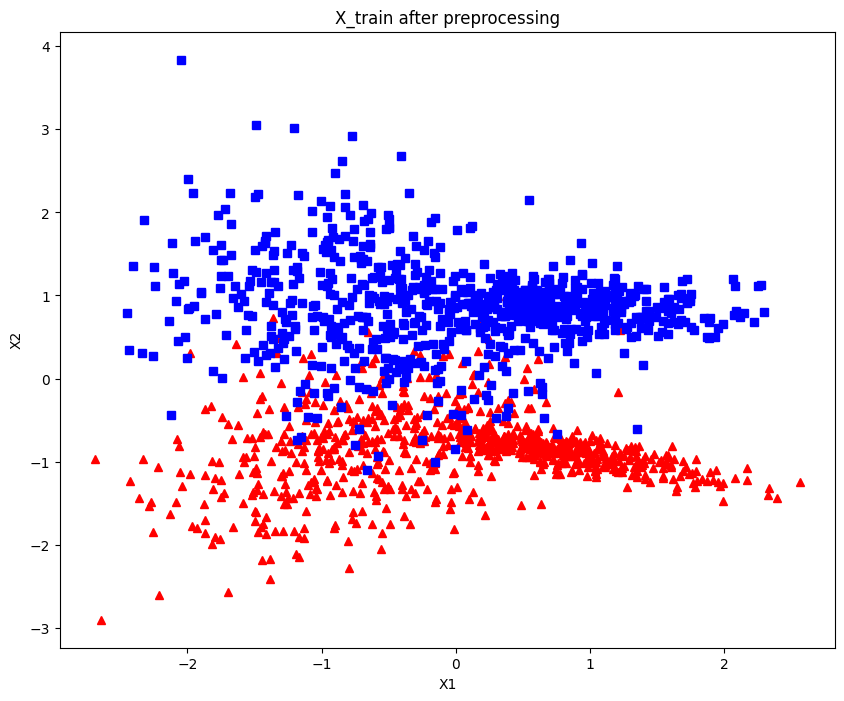

In [ ]:
#Plot again to see the effect of StandardScaler on Data
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(X_train_tr[:, 0][y_train == 0], X_train_tr[:, 1][y_train == 0], 'r^')
plt.plot(X_train_tr[:, 0][y_train == 1], X_train_tr[:, 1][y_train == 1], 'bs')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title('X_train after preprocessing')

Classification tasks may require some preprocessing of the ground truth.

In this case, we want to define a MLP where the output layer is equal to the number of classes of the task, so we need to modify the true labels. We need to convert the ground-truth to the so called hot encoding.

As an example, suppose that we have  y=[cat,dog,cat,cat] , we assign the vector  cat=[1,0] , and  dog=[0,1] as we have two possible classes as output.
Using this conversion strategy, we would obtain the following:  y=[[1,0],[0,1],[1,0],[1,0]] .

In [ ]:
# step 3.2 transforn y using to_categorical (keras one hot encoding function)
from keras.utils import to_categorical

num_classes=2

# trasform y_train from single vector to categorical (2 classes)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(y_train[:5])
print(y_train_cat[:5])

[1 0 0 1 0]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


### Step 4: Model definition

A Sequential model is used when you have a **plain stack of layers** on top of each other and each layer has one input/output.
for this implementation we use [Sequential API](https://keras.io/guides/sequential_model/#:~:text=from%20the%20start%3A-,model%20%3D%20keras.Sequential(),-model.add) and we add whatever layers we require to that.

In [ ]:
# Sequential = ogni nodo collegato al layers successivo
from keras.models import Sequential

# Dense: ogni nodo connesso ad ogni nodo del layers successivo
from keras.layers import Dense

import tensorflow as tf

Look carefully: add the three lines for fixing the seed in each cell defining a new model. This ensures that the results we get are reproducible.

In [ ]:
# fix the seeds ----- IMPORTANT
np.random.seed(123)
tf.random.set_seed(2)
tf.keras.utils.set_random_seed(10)

# set tensorflow as detrministic
tf.config.experimental.enable_op_determinism()

# obtain the input size, and number of classes.
# these two numbers are mandatory for the input and output layers, respectively
feature_vector_length = X_train.shape[1]
num_classes = 2


# define a new Sequential model
## currently, the model is empty
model = Sequential()

We add the first dense layer. Note: the first dense layer requires that we specify the expected input dimension, so that Keras can check if the examples given as input have the correct size.

In [ ]:
# add the first layer
# Dense layers with parameters:
    # units = how many nodes in the layers
    # activation = activation function
    # input_dim = dimension of the previous layer

model.add(Dense(input_dim = feature_vector_length, units=128 , activation='relu')) #first layer

Our model now looks like the following figure, where $x$ is the input, $|x| = i = 2$, $n$ represents our neurons, and $j = 128$.

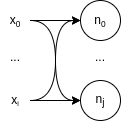

We now add a new layer, the output. This layer requires a *softmax* function.
Note that we do not need to specify the input size since Keras derives this information automatically (i.e., it is the number of neurons of the previous layer).

In [ ]:
# add the output layer
model.add(Dense(num_classes, activation='softmax')) #output layer

Our model now looks like the following Figure.

This new layer contains 2 nodes, one per target class, and the output is a probability vector $p = [p_0, p_1]$.


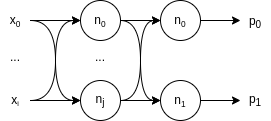

In [ ]:
# compile the model
# compile = compilation of the model (create the network for us) -> parameters:
    # loss = loss function
    # optimizer = what algorithm we want to use
    # metrics

model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])

**Note**

*model.compile* specifies the loss function, the optimizer and the metrics.  *model.compile* does not perform trainins, so it doesn't modify weights.


In other words, compiling a model as many times as you want does not have any effect on pretrained weights.

### Step 5: Model Summary

Keras provides a way to check the model information which is called model summary.

The summary concludes of the following information:

* The layers and their order in the model.
* The output shape of each layer.
* The number of parameters (weights) in each layer.
* The total number of parameters (weights) in the model.









In [ ]:
# see model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 642 (2.51 KB)
Trainable params: 642 (2.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


*plot_model* converts a Keras model to **dot format**, which provides a graph representation of model, and saves it to a file. Notice that with this command shows the input layer as well.

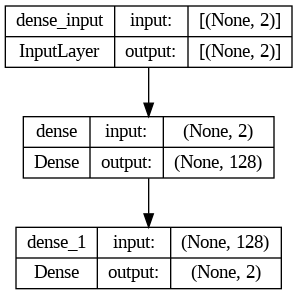

In [ ]:
# see graph representation of model summary
from keras.utils import plot_model

plot_model(model, show_shapes= True)

### Step 6: train the model

We now fit our model. The function requires some datapoints (*X_train*), the ground truth (*y_train*) and the number of epochs (an epoch has passed when, during training, we have used all of the data exactly once).

For this execution, we set the number of epochs to 20, but we are going to see a smart trick later on that helps us deciding the proper amount of epochs.

The *verbose* parameter defines the level of information (a.k.a. prints) we are going to see during the training process. If 0, we won't see any output, if 1, we are going to see the model's performance at each iteration.

Finally, *validation_split* defines the amount of data we use from the training set as validaiton. In this case, we reserve 20\% of the training data.

Another common parameter for *fit* is *batch_size*, for instance *batch_size=16*, which specify the number of samples over which the gradient is computed at each iteration (we are not seeing it in the example below but we'll use it in the exercises).


In [ ]:
history = model.fit(X_train_tr, y_train_cat, epochs=20, verbose=1, validation_split = 0.20, shuffle=False)
# history = full story of the training

Epoch 1/20
40/40 [==============================] - 4s 37ms/step - loss: 0.6150 - accuracy: 0.8227 - val_loss: 0.5527 - val_accuracy: 0.9219
Epoch 2/20
40/40 [==============================] - 0s 10ms/step - loss: 0.5053 - accuracy: 0.9344 - val_loss: 0.4596 - val_accuracy: 0.9312
Epoch 3/20
40/40 [==============================] - 0s 11ms/step - loss: 0.4254 - accuracy: 0.9391 - val_loss: 0.3915 - val_accuracy: 0.9406
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 0.3654 - accuracy: 0.9430 - val_loss: 0.3408 - val_accuracy: 0.9375
Epoch 5/20
40/40 [==============================] - 1s 21ms/step - loss: 0.3201 - accuracy: 0.9438 - val_loss: 0.3029 - val_accuracy: 0.9375
Epoch 6/20
40/40 [==============================] - 1s 15ms/step - loss: 0.2856 - accuracy: 0.9445 - val_loss: 0.2745 - val_accuracy: 0.9344
Epoch 7/20
40/40 [==============================] - 0s 8ms/step - loss: 0.2592 - accuracy: 0.9445 - val_loss: 0.2530 - val_accuracy: 0.9344
Epoch 8/20
40/

**history** records thetraining metrics for each epoch. It consists in the loss and accuracy of the model during training and also the loss and accuracy for the validation dataset if it is given as a parameter.

The **history** object is returned from calling the fit() function, which is used to train our model.
Metrics are returned as a dictionary in the **history** object.

You can list the metrics that are stored in the dictionary using the following code:
print(history.history.keys())

We use **history** to visualize the loss/accuracy of our model across the epochs.

### Step 7: evaluate the model

We can evaluate the model's performance using the *evaluate* function.

In [ ]:
scores = model.evaluate(X_test_tr, y_test_cat, verbose=0)

print("Model loss: %.4f" % (scores[0]))
print("Model Accuracy: %.2f%%" % (scores[1]*100))


Model loss: 0.2285
Model Accuracy: 89.33%


## Step 8: Visualize the loss

As we said, *history* records information about the model's performance among the epochs. Stored are the records of accuracy and loss for both training and validation sets.

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


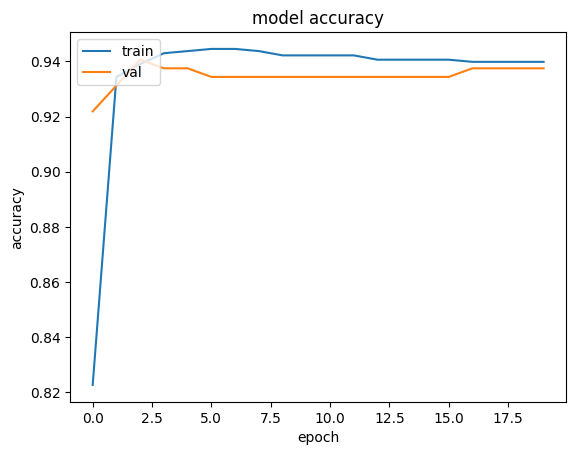

In [ ]:
# summarize history for accuracy for both train and validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

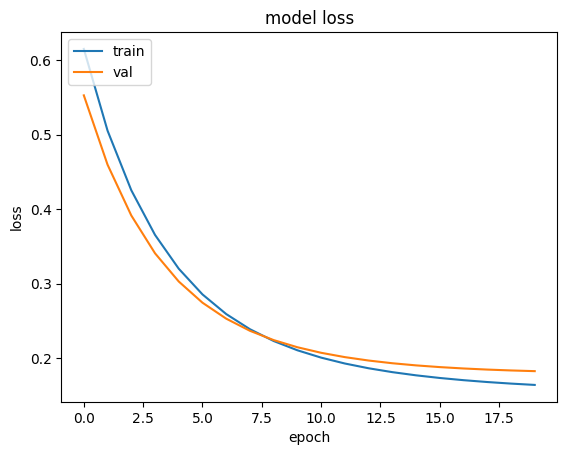

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

______________________________________________________________________________

# Exercise 1

In this first exercise, we are going to guide you through several experiments on a dataset almost identical to the previous one.


Text(0.5, 1.0, 'Random Classification Data with 2 classes')

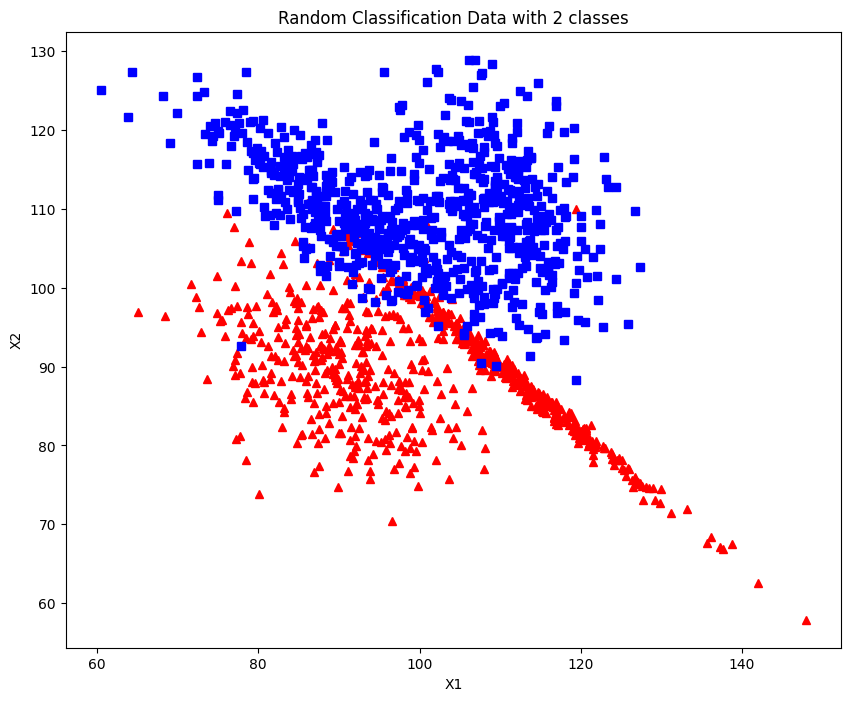

In [ ]:
from sklearn import datasets
import numpy as np

#set the seed and generate the dataset
np.random.seed(123)
X, y = datasets.make_classification(n_samples=1500, n_features=2, random_state=123, n_redundant= 0, scale=10, shift=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)


#Plotting
fig = plt.figure(figsize=(10,8))
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'r^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title('Random Classification Data with 2 classes')

## Ex1.1

Create a MLP called $model1$ with two layers:

1.   one input layer with 2 neurons and relu as activation function.
2.   one output layer.

Then, train it for 5 epochs, batch size = 16, shuffle = False and a validation set of 25%. Remember to set the seeds (np.random.seed, tf.random.set_seed, tf.keras.utils.set_random_seed) as shown in step 4!


In [ ]:
## EX1.1 HERE

# fix the seeds
np.random.seed(123)
tf.random.set_seed(2)
tf.keras.utils.set_random_seed(10)

# trasform y_train from single vector to categorical (2 classes)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# obtain the input size, and number of classes.
feature_vector_length = X_train.shape[1]
num_classes = 2

# create the model
model1 = Sequential()

model1.add(Dense(input_dim = feature_vector_length, units = 2, activation = 'relu')) #first layer
model1.add(Dense(num_classes, activation='softmax')) #output layer

# compile the model
model1.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])

# see model summary
model1.summary()

# plot
plot_model(model1, show_shapes= True)

# train
history = model1.fit(X_train, y_train_cat, epochs = 5, batch_size = 16, validation_split = 0.25, shuffle=False)

# model scores
scores = model1.evaluate(X_test, y_test_cat, verbose=0)
print("Model loss: %.4f" % (scores[0]))
print("Model accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 2)                 6         
                                                                 
 dense_45 (Dense)            (None, 2)                 6         
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
57/57 [==============================] - 2s 11ms/step - loss: 2.9886 - accuracy: 0.5044 - val_loss: 0.6930 - val_accuracy: 0.5233
Epoch 2/5
57/57 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4844 - val_loss: 0.6929 - val_accuracy: 0.5233
Epoch 3/5
57/57 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.4978 - val_loss: 0.6928 - val_accuracy: 0.52

## Ex 1.2

Plot both the accuracy and loss curve.

Answer the following:

1.   Is there any underfitting / overfitting problem?
2.   How is the training curve shaped?



In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


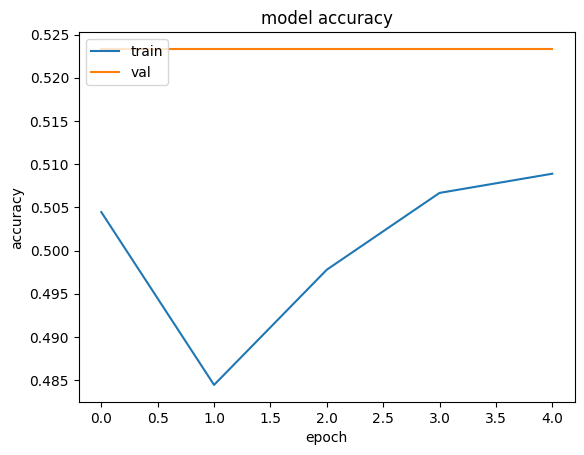

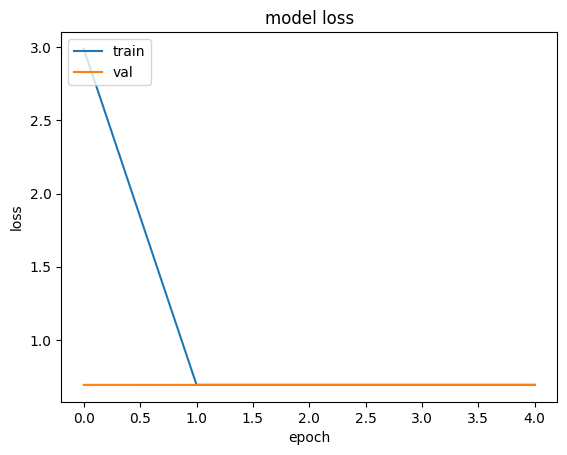

In [ ]:
### Ex1.2 HERE

# summarize history for accuracy for both train and validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The training loss function does not improve over the epochs, and this is reflected by the poor accuracy in both training and test sets (i.e., 0.50 and 0.52, respectively).

Considering that the dataset is balanced over the two target classes, the model is just randomly guessing. This means that currently the model is *underfitted* and not able to learn any useful information from the data. Usually, we might try two ways to address or mitigate the problem:
1.   Inspecting our data. The problem may not be the model, but the data. We need to verify that our data is in a ``*good shape*'' for a machine learning model.
2.   Increasing the model complexity. Our model might be just too simple for the task.

Before trying to make our model more complex, let’s first check that there isn’t anything “wrong” with our data.

## Ex1.3

As we introduced in our last lesson, the goal of a good data scientist is not only to provide a good training model, but he / she needs to know the data they are experimenting with. </br>
When working with a dataset, try to answer to the following:


1.   Is the ground truth balanced among the classes? If we are working with an unbalanced dataset, we need to be more careful with how we compute the performance.
2.   What are the properties of the input features? For each feature, you can understand the following: i) is it defined in the discrete or continuous domain? If defined in the continous domain, how is it distributed? For example, print the minimum and maximum values for each feature.

Based on the answers, we can "improve" our training strategy.




In [ ]:
# checking class balance in the dataset by counting labels
from collections import Counter

Counter(y)

Counter({0: 749, 1: 751})

The ground truth is completely balanced. Let's see how the features looks like by finding minimum, maximum and mean for each of them.

In [ ]:
### Ex1.3 HERE

def minimo_massimo(X, feature):
  min = X[0, feature]
  max = X[0, feature]
  for i in range(len(X)):
    if X[i,feature] < min:
      min = X[i, feature]
    if X[i, feature] > max:
      max = X[i, feature]
  print("Feature:", feature, "\nMinimum value:", min)
  print("Maximum value:", max)
  print("Mean:", (max+min)/2)


minimo_massimo(X, 0)
print()
minimo_massimo(X, 1)

Feature: 0 
Minimum value: 60.490427673075956
Maximum value: 147.87156388050605
Mean: 104.18099577679101

Feature: 1 
Minimum value: 57.904387374925435
Maximum value: 128.88776400578956
Mean: 93.39607569035749


Ok. This might be an issue for our training model. \
Neural Networks are trained with optimizers based on the gradient.
This implies that the optimization might not be efficient when the features are not defined in small ranges (i.e., [-1, 1]).


## Ex 1.4

We can try to now improve our model by scaling the features. Use a standard scaler to scale $X_{train}$ and $X_{test}$. Create a new MLP $model2$ and train it with the same configurations (architecture, training strategy) as done for $model1$.

Then we'll do some plots to check the accuracy and loss of the latest model and finally compare it with the previous one (see below for details).
Remember to set the seeds (np.random.seed, tf.random.set_seed, tf.keras.utils.set_random_seed)!

In [ ]:
### Ex1.4 HERE

# fix the seeds
np.random.seed(123)
tf.random.set_seed(2)
tf.keras.utils.set_random_seed(10)

scaler = StandardScaler()
X_train_tr = scaler.fit_transform(X_train)
X_test_tr = scaler.transform(X_test)

# create the model
model2 = Sequential()

model2.add(Dense(input_dim = feature_vector_length, units = 2, activation = 'relu')) #first layer
model2.add(Dense(num_classes, activation='softmax')) #output layer

# compile the model
model2.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])

# see model summary
model2.summary()

# plot
plot_model(model2, show_shapes= True)

# train
history2 = model2.fit(X_train_tr, y_train_cat, epochs = 5, batch_size = 16, validation_split = 0.25, shuffle=False)

# model scores
scores = model2.evaluate(X_test_tr, y_test_cat, verbose=0)
print("Model loss: %.4f" % (scores[0]))
print("Model accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 2)                 6         
                                                                 
 dense_31 (Dense)            (None, 2)                 6         
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
57/57 [==============================] - 1s 6ms/step - loss: 0.6464 - accuracy: 0.7389 - val_loss: 0.5721 - val_accuracy: 0.8067
Epoch 2/5
57/57 [==============================] - 0s 3ms/step - loss: 0.5667 - accuracy: 0.7800 - val_loss: 0.5180 - val_accuracy: 0.8300
Epoch 3/5
57/57 [==============================] - 0s 3ms/step - loss: 0.5136 - accuracy: 0.8133 - val_loss: 0.4778 - val_accuracy: 0.846

Let's now plot the accuracy and the loss of our latest model on the train and validation sets.

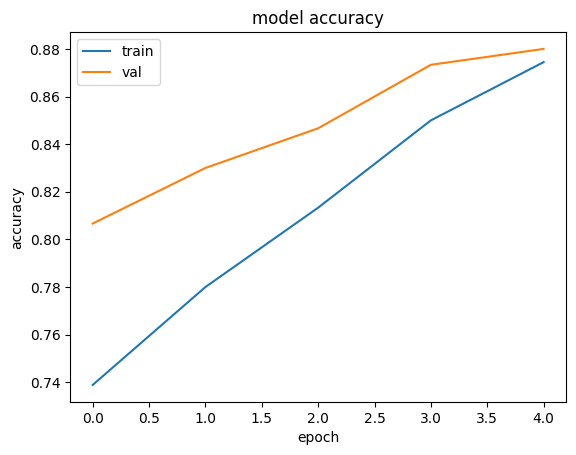

In [ ]:
# plot history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

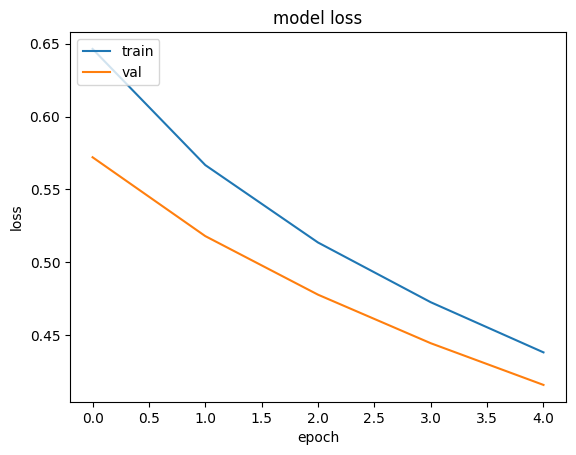

In [ ]:
# plot history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Let's now compare the performance of the two models on the validation set. By using the scaled features, we have improved the accuracy on the validation set from 0.52 to 0.84, it also increases "regularly". \
Maybe if we keep training it will keep improving? \

## Ex1.5

Let's do it. \
For example, we can train a new MLP $model3$ for 50 epochs.
Print loss and accuracy curves, and then visually analyze them. \
Again, use the same configuration as $model1$, and remember the seeds.


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 2)                 6         
                                                                 
 dense_37 (Dense)            (None, 2)                 6         
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
57/57 [==============================] - 1s 7ms/step - loss: 0.6464 - accuracy: 0.7389 - val_loss: 0.5721 - val_accuracy: 0.8067
Epoch 2/50
57/57 [==============================] - 0s 3ms/step - loss: 0.5667 - accuracy: 0.7800 - val_loss: 0.5180 - val_accuracy: 0.8300
Epoch 3/50
57/57 [==============================] - 0s 3ms/step - loss: 0.5136 - accuracy: 0.8133 - val_loss: 0.4778 - val_accuracy: 0.

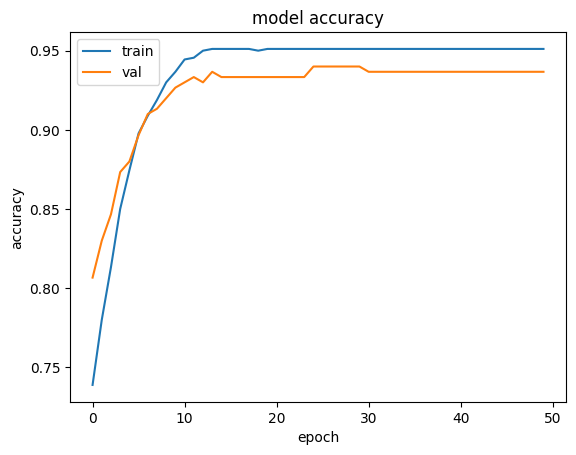

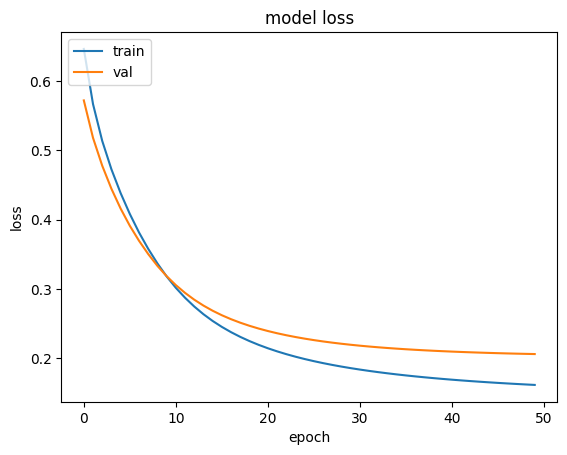

In [ ]:
# EX 1.5

# fix the seeds
np.random.seed(123)
tf.random.set_seed(2)
tf.keras.utils.set_random_seed(10)

scaler = StandardScaler()
X_train_tr = scaler.fit_transform(X_train)
X_test_tr = scaler.transform(X_test)

# create the model
model3 = Sequential()

model3.add(Dense(input_dim = feature_vector_length, units = 2, activation = 'relu')) #first layer
model3.add(Dense(num_classes, activation='softmax')) #output layer

# compile the model
model3.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])

# see model summary
model3.summary()

# plot
plot_model(model3, show_shapes= True)

# train
history3 = model3.fit(X_train_tr, y_train_cat, epochs = 50, batch_size = 16, validation_split = 0.25, shuffle=False)

# model scores
scores = model.evaluate(X_test_tr, y_test_cat, verbose=0)
print("Model loss: %.4f" % (scores[0]))
print("Model accuracy: %.2f%%" % (scores[1]*100))


# plot history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


# plot history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The charts show some common training trends. For example, let's consider the loss:


1.   In the early stages (epoch 1 - 15), there is a phase where the model loss decreases quickly.
2.   From epoch 16 to 25, there is a stabilization trend, where the model improves at a lower rate, and it might seem that the training is almost done. Then there is a new phase of improvement.
3.   After epoch 30, the loss does not improve much, it decreases very slowly.

## Ex1.6

If our model stops improving during training, we are still stuck with training it for the number of epochs we set. However, we can save our time by introducing an **early stopping mechanism** <a href = "https://keras.io/api/callbacks/early_stopping/"> [link] </a>.
For example, during the training, if the model validation loss does not improve
for 3 epochs, we decide to stop.
In this way, we can even set the number of epochs to 10000. When the model stops improving the training will stop.

We define a fourth MLP $model4$ with the early stopping mechanism with patience = 3 (number of epochs with no improvement after which we stop the trainin process). Use the same configuration and seeds of $model1$.
Train the model for 500 epochs, and then plot the accuracy and loss curves.



In [ ]:
from keras.callbacks import EarlyStopping

# simple early stopping
es = EarlyStopping(monitor='val_loss', #quantity to be monitored
                   mode='min', #we look for decreasing patterns stop
                   patience = 3, #number of epochs with no improvement
                   verbose=1)

#seed
np.random.seed(123)
tf.random.set_seed(2)
tf.keras.utils.set_random_seed(10)

# Create the model
model4 = Sequential() #we first define how the "model" looks like
model4.add(Dense(input_dim = feature_vector_length, units=2 , activation='relu')) #input layer
model4.add(Dense(num_classes, activation='softmax')) #output layer

#see how the model looks like
model4.summary()

# Configure the model and start training
model4.compile(loss='categorical_crossentropy', #loss metric
              optimizer='sgd',  #optimizer
              metrics=['accuracy']) #displayed metric

#train our model
history4 = model4.fit(X_train_tr, y_train_cat, epochs=500, verbose=0, validation_split=0.25, callbacks=[es], shuffle=False)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 2)                 6         
                                                                 
 dense_39 (Dense)            (None, 2)                 6         
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 271: early stopping


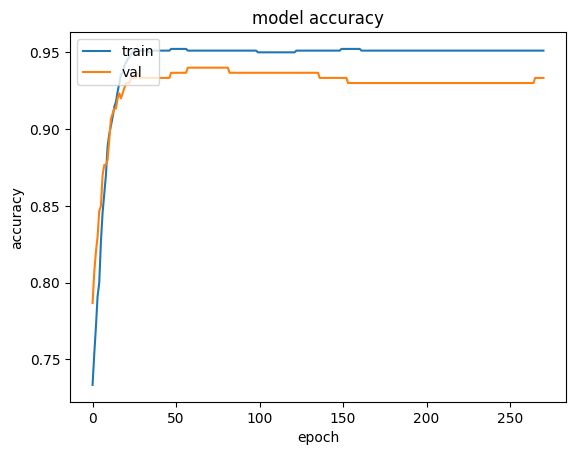

In [ ]:
# plot history for accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

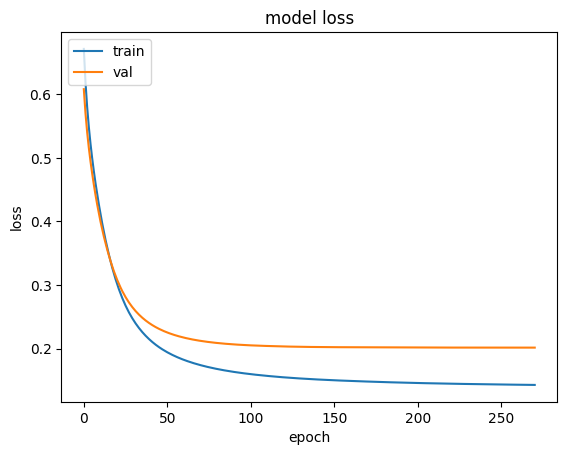

In [ ]:
# plot history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

We see that the model stopped at epoch 200. </br>

We created so far $4$ models, with four different training strategy, but the same architecture. \

The fourth model seems the best based on the validation accuracy and loss, we can now see if it's the best on the test set as well.
Evaluate all four models on the tset set and print their accuracy.

In [ ]:
### Ex1.6

scores1 = model1.evaluate(X_test, y_test_cat, verbose=0)
scores2 = model2.evaluate(X_test_tr, y_test_cat, verbose=0)
scores3 = model3.evaluate(X_test_tr, y_test_cat, verbose=0)
scores4 = model4.evaluate(X_test_tr, y_test_cat, verbose=0)

print("Model 1")
print("Model loss: %.4f" % (scores1[0]))
print("Model Accuracy: %.2f%%" % (scores1[1]*100))
print()

print("Model 2")
print("Model loss: %.4f" % (scores2[0]))
print("Model Accuracy: %.2f%%" % (scores2[1]*100))
print()

print("Model 3")
print("Model loss: %.4f" % (scores3[0]))
print("Model Accuracy: %.2f%%" % (scores3[1]*100))
print()

print("Model 4")
print("Model loss: %.4f" % (scores4[0]))
print("Model Accuracy: %.2f%%" % (scores4[1]*100))
print()

Model 1
Model loss: 0.6944
Model Accuracy: 44.67%

Model 2
Model loss: 0.4338
Model Accuracy: 89.00%

Model 3
Model loss: 0.1674
Model Accuracy: 94.00%

Model 4
Model loss: 0.1458
Model Accuracy: 94.33%



# Ex 2

In this new exercise, it's time to be more independent from us. \
Try and get good performances on the *wine_dataset*.

Adopt the tips we saw in this lecture. \

Remember: use the testing set only *at the end*, after you selected the best model.


In [ ]:
from sklearn.datasets import load_wine #load our target dataset

#load the dataset
dataset = load_wine()

#extract X and y
X = dataset.data
y = dataset.target

#split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)